In [1]:
# all internal libraries
import pathlib
import time
import datetime
import io
import urllib
import tempfile

# dependencies
import shapely.geometry
import networkx as nx
import simpy
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation



# our software
import opentnsim.core
from external import network 

%matplotlib inline

In [2]:
# link to the latets version of the network
url = 'https://zenodo.org/record/3981105/files/network_digital_twin_v0.1.yaml'
G = network.load_fis_network(url)

## Repeat for real case

In [168]:
# Creating a library of some interesting locations

def find_closest_node(G, point):
    distance = np.full((len(G.nodes)), fill_value=np.nan)
    for ii, n in enumerate(G.nodes):
        distance[ii] = point.distance(G.nodes[n]['geometry'])
    name_node = list(G.nodes)[np.argmin(distance)]
    distance_node = np.min(distance)
    return name_node, distance_node


def find_closest_edge(G, point):
    distance = np.full((len(G.edges)), fill_value=np.nan)
    for ii, e in enumerate(G.edges):
        distance[ii] = point.distance(G.edges[e]['geometry'])
    name_edge = list(G.edges)[np.argmin(distance)]
    distance_edge = np.min(distance)
    return name_edge, distance_edge

locations = {
    'Transferium Maasvlakte': shapely.geometry.Point(4.087406, 51.936737),
    'Neusse': shapely.geometry.Point(6.708892, 51.215737),
    'Basel': shapely.geometry.Point(7.640572, 47.555449)
}

locations_nodes = {n: find_closest_node(G, locations[n])[0] for n in locations}


In [178]:
# Find basic route
start_point = locations_nodes['Transferium Maasvlakte']
end_point = locations_nodes['Basel']
path = nx.dijkstra_path(G, start_point, end_point, weight='Length')

In [6]:
env = simpy.Environment()

In [7]:
simulation_start = datetime.datetime(2018, 7, 1)
env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
env.epoch = time.mktime(simulation_start.timetuple())

# Add graph to environment
env.FG = G

In [8]:
# Make a class out of mix-ins
TransportResource = type('TransportResource', 
                         (opentnsim.core.Identifiable, opentnsim.core.ContainerDependentMovable, 
                          opentnsim.core.HasResource, opentnsim.core.Routeable), {})



# For testing purposes we only want v to be 1
def compute_v_provider(v_empty, v_full):
    return lambda x: 1

data_vessel = {"env": None,
               "name": "Vessel number 1",
               "route": None,
               "geometry": G.nodes[start_point]['geometry'],  # lon, lat
               "capacity": 1_000,
               "compute_v": compute_v_provider(v_empty=1, v_full=1)}

# create the transport processing resource
vessel = TransportResource(**data_vessel)

In [9]:
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Log, opentnsim.core.Locatable, opentnsim.core.HasResource), {})

data_node_1 = {"env": [],
               "name": "Node 1",
               "geometry": G.nodes[start_point]['geometry']}
data_node_2 = {"env": [],
               "name": "Node 2",
               "geometry": G.nodes[end_point]['geometry']}

node_1 = Node(**data_node_1)
node_2 = Node(**data_node_2)

nodes = [node_1, node_2]


In [195]:
# # Add environment and path to the vessel
vessel.env = env
route = nx.DiGraph(G.subgraph(path))
vessel.route = path

In [11]:
def start(env, vessel):
    vessel.log_entry("Start sailing", env.now, "", vessel.geometry)
    yield from vessel.move()
    vessel.log_entry("Stop sailing", env.now, "", vessel.geometry)
        
env.process(start(env, vessel))
env.run()


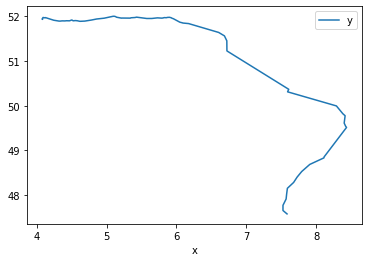

In [12]:
# get log and plot track
df = pd.DataFrame.from_dict(vessel.log)
df['x'] = df.Geometry.apply(lambda geom: geom.x)
df['y'] = df.Geometry.apply(lambda geom: geom.y)
df.plot('x', 'y')

In [177]:
import scipy.interpolate

# Waterdiepte uitrekenen op meerdere plekken in het netwerk (Q-waterdiepte-relatie)
# Load the depth tables
depth_path = pathlib.Path('~/data/vaarwegen/discharge/depth.csv')
discharge_df = pd.read_csv(depth_path)

# get the discharge interpolation functions
discharge_df = discharge_df.rename(columns={'Unnamed: 0': 'Lobith'})
discharge_df = discharge_df.set_index('Lobith')
F = discharge_df.apply(lambda series: scipy.interpolate.interp1d(series.index, series.values))

# add some coordinates
coordinates = {
    'Kaub': shapely.wkt.loads("POINT(7.764967 50.085433)"),
    'Duisburg-Ruhrort': shapely.wkt.loads("POINT(6.727933 51.455350)"),
    'Emmerich': shapely.wkt.loads("POINT(6.245600 51.829250)"),
    'Erlecom': shapely.wkt.loads("POINT(5.95044 51.86054)"),
    'Nijmegen': shapely.wkt.loads("POINT(5.84601 51.85651)"),
    'Ophemert': shapely.wkt.loads("POINT(5.41371 51.85023)"),
    'St. Andries': shapely.wkt.loads("POINT(5.33567 51.80930)"),
    'Zaltbommel': shapely.wkt.loads("POINT(5.24990 51.81733)"),
    'Nijmegen (fixed layer)': shapely.wkt.loads("POINT(5.85458 51.85264)")
}
# store in a DataFrame
depth_df = pd.DataFrame(F, columns=['F'])
# add the geometry
depth_locations_df = pd.DataFrame(data=coordinates.items(), columns=['location', 'geometry']).set_index('location')
# merge back together
depth_df = pd.merge(depth_df, depth_locations_df, left_index=True, right_index=True)
depth_df.loc['Kaub']

F           <scipy.interpolate.interpolate.interp1d object...
geometry                           POINT (7.764967 50.085433)
Name: Kaub, dtype: object

In [180]:
# lookup closest locations
location_edge = {}
for name, row in depth_df.iterrows():
    location_edge[name] = find_closest_edge(G, row.geometry)[0]
# merge closest edges with the table
edges_df = pd.DataFrame(location_edge).T.rename(columns={0: 'edge_from', 1: 'edge_to'})
depth_df = pd.merge(depth_df, edges_df, left_index=True, right_index=True)

In [212]:
depth_df['on_route'] = depth_df.apply(lambda x: route.has_edge(x.edge_from, x.edge_to), axis=1)
depth_df

,F,geometry,edge_from,edge_to,on_route
Kaub,<scipy.interpolate.interpolate.interp1d object...,POINT (7.764967 50.085433),FN278,FN284,True
Duisburg-Ruhrort,<scipy.interpolate.interpolate.interp1d object...,POINT (6.727933 51.45535),FN206,FN212,False
Emmerich,<scipy.interpolate.interpolate.interp1d object...,POINT (6.2456 51.82925),8.86116e+06,FN224,True
Erlecom,<scipy.interpolate.interpolate.interp1d object...,POINT (5.95044 51.86054),8.86323e+06,B25279_A,False
Nijmegen,<scipy.interpolate.interpolate.interp1d object...,POINT (5.84601 51.85651),8.86335e+06,B8661453_A,False
Ophemert,<scipy.interpolate.interpolate.interp1d object...,POINT (5.41371 51.85023),8.86563e+06,8.86574e+06,False
St. Andries,<scipy.interpolate.interpolate.interp1d object...,POINT (5.33567 51.8093),8.86574e+06,B21116_A,False
Zaltbommel,<scipy.interpolate.interpolate.interp1d object...,POINT (5.2499 51.81733),8.8632e+06,B28687_B,False
Nijmegen (fixed layer),<scipy.interpolate.interpolate.interp1d object...,POINT (5.85458 51.85264),8.86335e+06,B53618_B,False


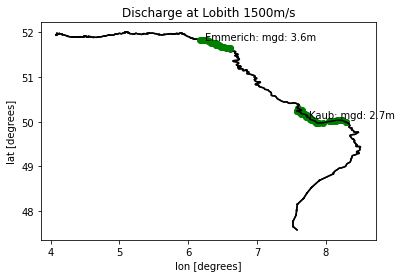

In [240]:
# Op gegeven route is de laagste waterdiepte maatgevend

lobith_discharge = 1500

depth_idx = depth_df.reset_index().rename(columns={'index': 'name'}).set_index(['edge_from', 'edge_to'])
fig, ax = plt.subplots()
ax.set_title("Discharge at Lobith {:.0f}m/s".format(lobith_discharge))
ax.set_xlabel('lon [degrees]')
ax.set_ylabel('lat [degrees]')
for e in route.edges():
    pts = np.array(route.edges[e]['geometry'])
    style = 'k-'
    if e in depth_idx.index:
        style = 'g-o'
        row = depth_idx.loc[e]
        label = "{}: mgd: {:.1f}m".format(row['name'], row.F(lobith_discharge))
        ax.text(row.geometry.x, row.geometry.y, label)
    ax.plot(pts[:, 0], pts[:, 1], style)

In [236]:
# Compute minimum depth on the network
min_depth = depth_df[depth_df.on_route].apply(lambda x: x.F(lobith_discharge), axis=1).min()
min_depth

2.696526777236506

In [243]:
# De diepgang is dan bepaalt met [waterdiepte - 0.30 m].
underkeel_clearance = 0.30
maximum_draught = min_depth - underkeel_clearance
maximum_draught

2.396526777236506

In [247]:
# De beladingsgraad is dan [(Diepgang - Diepgang_ledig)/(Diepgang_vol - Diepgang_ledig)]
# Example ship https://gallemakelaars.nl/justin
# Diepgang (M)3,70
# Ledig Gemiddeld (M)0,85
draught_empty = 0.85
draught_full = 3.7
load_fraction = (maximum_draught - draught_empty)/(draught_full - draught_empty)
load_fraction

# Number of extra ships
1 / load_fraction

# Het aantal schepen dat je nodig hebt voor transport van dezelfde goederen is dan [n=1/beladingsgraad]

1.8428390907609598

In [108]:
# Interpolate data to 1 hour timeseries

df_interpolated = (
    df[['x', 'y', 'Timestamp']]
    # Get rid of double (start/stop) log entries
    .drop_duplicates('Timestamp')
    .set_index('Timestamp')
    # Resample to hourly data
    .resample('H')
    # backfill so that we do not have missings at t=0
    .bfill(limit=1)
    # Interpolate values 
    .interpolate('linear')
    # Get rid of the first/last measurement
    .dropna()
    # restore the Timestamp as a column
    .reset_index()
)




In [109]:
# Create plot of results
    
# Make the animation
fig, ax = plt.subplots(figsize = [12, 12])
ax.set_xlim(df['x'].min(), df['x'].max())
ax.set_ylim(df['y'].min(), df['y'].max())


location, = ax.plot([], [], 'kx', markersize=10)
path, = ax.plot([], [], 'g-', markersize=8)
time_text = ax.set_title("")


spatial_pos = {
    k: (v['X'], v['Y']) 
    for k, v 
    in G.nodes.items()
}

nx.draw(
    G, 
    spatial_pos, 
    with_labels = False, 
    node_size = 0,
    font_size = 2, 
    width = 0.2, 
    arrowsize = 3
)

def init():
    location.set_data([], [])
    path.set_data([], [])
    time_text.set_text("Time is 0")
    return location, path, time_text

def animate(i_row):
    i, row = i_row
    location.set_data(row.x, row.y)
    time_text.set_text("Time is {}".format(row.Timestamp))
    history = df_interpolated.iloc[:i]
    path.set_data(history.x, history.y)
    return location, path, time_text
    
        


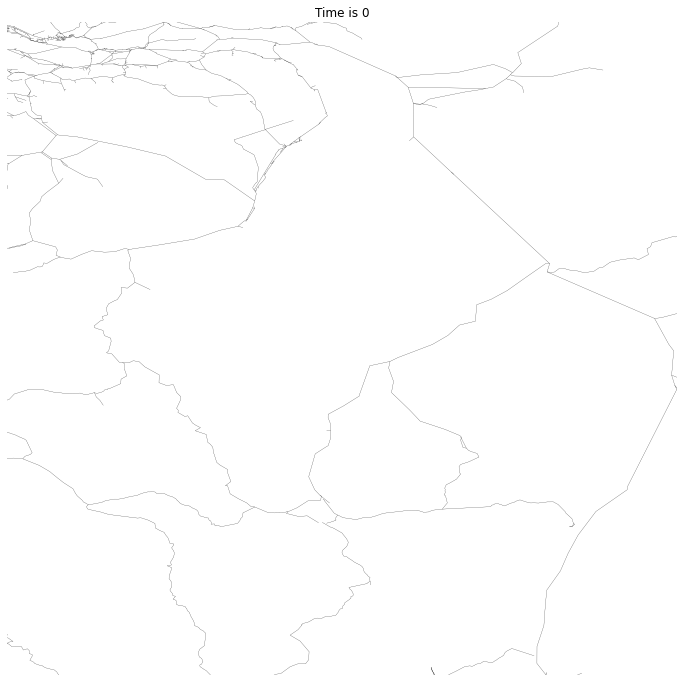

In [107]:
ani = animation.FuncAnimation(fig, animate, list(df_interpolated.iterrows()), init_func=init)
ani.save('route.mp4', fps=5)